# Final Project - Part A

## Question 5

In [56]:
#Q5 To change
maFast = 31
maSlow = 222
bbWindow = 20
bbStdevBand = 3
myStrategies = ['AAPL-MAFlat', 'AMZN-BMK-MA', 'ATT-BB', 'EUR-MAShort', 'FBNDX-MAShort', 'GE-MAShort', 'GOLD-MAShort', 'SPY-MAFlat']

## Initializing the previously used custom functions

In [57]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import numpy as np
aspect_ratio = (12, 8) # if plotting inline
# aspect_ratio = (8, 5) # if plotting in separate windows using qt
from itertools import product
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

### 1) Read Price Data Function

In [58]:
def read_price_data(fileName, index_col=0, parse_dates=True):
    df = pd.read_csv(fileName, index_col=index_col, parse_dates=parse_dates)
    #check info of dataframe
    print(df.info())
    # check if any NULL values
    print(df.isnull().sum())
    # summary statistics
    print(df.describe())
    return df

### 2) Plot and Format Y-axis Function

In [59]:
def plot_and_format_y_axis(data_frame, 
                           formatter=mticker.ScalarFormatter(), 
                           aspect_ratio=(12,8), 
                           title='', 
                           ylabel='', 
                           grid=True,
                           label=None):
    # Set the aspect ratio for the plot
    plt.figure(figsize=aspect_ratio)
    
    # Plot all columns of the DataFrame and pass the label to the plot function
    ax = data_frame.plot(label=label)

    # Set the formatter for the y-axis to show percentage figures
    ax.yaxis.set_major_formatter(formatter)

    # Set the plot title and y-axis label
    ax.set_title(title)
    ax.set_ylabel(ylabel)

    # Enable or disable the grid
    ax.grid(grid)

    # Print the legend if the label is provided
    #if label:
        #plt.legend()

    # Show the plot
    plt.show()

### 3) Print Percentage Data Function

In [60]:
def print_pct_data(data_frame, fmt="{:.4%}", na_rep="NaN", index_slice=None):
    
    # Create the styler object
    styled_df = data_frame.style
    
    if index_slice:
        # Apply formatting only to the specified slice of the DataFrame
        styled_df = styled_df.format(fmt, na_rep=na_rep, subset=pd.IndexSlice[index_slice])
    else:
        # Multiply the data by 100 to convert to percentage
        styled_df = styled_df.format(fmt, na_rep=na_rep)
    
    # Display the styled DataFrame
    return styled_df

In [61]:
percent_formatter = mticker.PercentFormatter(xmax=1)

### 4) Calculate Performance Statistics Function

In [62]:
def calcPerformanceStatistics(dataFrame, annualization_factor=260, print_Screen=True, percent_format_string="{:.2%}"):
    
    # Error checking for the first row of the returns DataFrame
    first_row = dataFrame.iloc[0]

    if not first_row.isna().all():  # If the first row doesn't contain all NaNs
        # Insert a NaN row at the top if there is no first NaN row
        print("First row does not contain all NaNs. Inserting a NaN row at the top.")
        nan_row = pd.DataFrame([np.nan] * dataFrame.shape[1], index=dataFrame.columns).T
        nan_row.index = pd.date_range(end=dataFrame.index[0] - pd.Timedelta(days=1), periods=1, freq='B')
        dataFrame = pd.concat([nan_row, dataFrame])
    elif (first_row.isna().any() and not first_row.isna().all()):
        raise ValueError("The first row contains partial NaN values. It should either be completely NaN or not at all.")
    elif (returns.iloc[1:].isna().any().any()):
        raise ValueError("There are NaN values in rows other than the first row.")
        
    cum_returns = dataFrame.cumsum()
    
    summary_stats = pd.DataFrame([annualization_factor*dataFrame.mean(),
                                  np.sqrt(annualization_factor)*dataFrame.std(),
                                  (dataFrame.mean() / dataFrame.std()) * np.sqrt(annualization_factor),
                                  (cum_returns.fillna(0) - np.maximum.accumulate(cum_returns.fillna(0))).min(axis=0),
                                  (dataFrame >= 0).sum() / (dataFrame.shape[0] - 1)],
                                  index=['Average Annual Return', 'Annual Risk', 'Sharpe Ratio', 'maxDD', 'Success Ratio'])
    
    # Define the index_slice for rows that should be formatted as percentages
    index_slice = pd.IndexSlice[['Average Annual Return', 'Annual Risk', 'maxDD', 'Success Ratio'], :]
    
    if print_Screen:
        styled_df = print_pct_data(summary_stats, fmt=percent_format_string, index_slice=index_slice)
        return styled_df

## 4) Moving Cross Average



In [63]:
def movingAverageCrossover(dataFrame, fastWindow, slowWindow):
    
    # Error-checking: Raise ValueError if the input DataFrame has more than one column
    if dataFrame.shape[1] != 1:
        raise ValueError("Input DataFrame must contain exactly one column of prices.")
        
    # Extract instrument name from the column name
    instrument_name = dataFrame.columns[0]
    
    # Calculate the fast and slow moving averages
    dataFrame.loc[:,'FastSMA'] = dataFrame[instrument_name].rolling(fastWindow).mean()
    dataFrame.loc[:,'SlowSMA'] = dataFrame[instrument_name].rolling(slowWindow).mean()
    
    #Drop NaN values
    dataFrame.dropna(inplace=True)
    
    # Calculate the log returns for the benchmark (BMK)
    dataFrame.loc[:,instrument_name + '-BMK-MA'] = np.log(dataFrame[instrument_name] / dataFrame[instrument_name].shift(1))
    
    # SMA strategy: if rising trend, stay long, otherwise go flat
    dataFrame.loc[:,'PositionFlat'] = np.where(dataFrame['FastSMA'] > dataFrame['SlowSMA'], 1, 0)
    # then calculate the Flat strategy returns, taking care to push down the PositionFlat column
    dataFrame.loc[:,instrument_name + '-MAFlat'] = dataFrame['PositionFlat'].shift(1) * dataFrame[instrument_name + '-BMK-MA']
    
    # SMA strategy: if rising trend, stay long, otherwise go short
    dataFrame.loc[:,'PositionShort'] = np.where(dataFrame['FastSMA'] > dataFrame['SlowSMA'], 1, -1)
    # then calculate the Short strategy returns, taking care to push down the PositionShort column
    dataFrame.loc[:,instrument_name + '-MAShort'] = dataFrame['PositionShort'].shift(1) * dataFrame[instrument_name + '-BMK-MA']
    
    # Return only the relevant columns
    dataFrame = dataFrame[[instrument_name + '-BMK-MA', instrument_name + '-MAFlat', instrument_name + '-MAShort']]
    
    return dataFrame

## 5) Bollinger Strategy

In [64]:
def bollingerBands(dataFrame, lookbackWindow, stdevBand):
    
    # Error-checking: Raise ValueError if the input DataFrame has more than one column
    if dataFrame.shape[1] != 1:
        raise ValueError("Input DataFrame must contain exactly one column of prices.")
        
    # Extract instrument name from the column name
    instrument_name = dataFrame.columns[0]
    
    # calculate the rolling mean and the rolling risk
    # remember to use .loc rather than just chain indexing because that's gives predictable results
    dataFrame.loc[:,'Mean'] = dataFrame[instrument_name].rolling(lookbackWindow).mean()
    dataFrame.loc[:,'Stdev'] = dataFrame[instrument_name].rolling(lookbackWindow).std()
    
    dataFrame.dropna(inplace=True)
    
    dataFrame.loc[:,'Upper'] = dataFrame['Mean'] + stdevBand * dataFrame['Stdev']
    dataFrame.loc[:,'Lower'] = dataFrame['Mean'] - stdevBand * dataFrame['Stdev']
    
    # initialize the first row based on the close price vis-a-vis the bands
    # here, we're also initializng a new column called 'Position'
    # using .loc as before
    date0 = dataFrame.index[0]
    if dataFrame.loc[date0,instrument_name] >= dataFrame.loc[date0, 'Upper']:
        dataFrame.loc[date0, 'Position'] = -1
    elif dataFrame.loc[date0,instrument_name] <= dataFrame.loc[date0,'Lower']:
        dataFrame.loc[date0, 'Position'] = 1
    else:
        dataFrame.loc[date0, 'Position'] = 0
    
    # then loop over the entire data set
    for i in range(1, dataFrame.shape[0]):
        today=dataFrame.index[i]
        yesterday=dataFrame.index[i-1]
        if dataFrame.loc[today,instrument_name] >= dataFrame.loc[today,'Upper']: # if close is above upper
            dataFrame.loc[today,'Position'] = -1 # then go short
        elif dataFrame.loc[today,instrument_name] <= dataFrame.loc[today,'Lower']: # if close is below lower
            dataFrame.loc[today,'Position'] = 1 # then go long
        elif dataFrame.loc[yesterday,'Position'] == -1 and dataFrame.loc[today,instrument_name] <= dataFrame.loc[today,'Mean']: # if prev day is short and we're now below the mean
            dataFrame.loc[today,'Position']=0 # then flatten
        elif dataFrame.loc[yesterday,'Position'] == 1 and dataFrame.loc[today, instrument_name] >= dataFrame.loc[today, 'Mean']: # conversely...
            dataFrame.loc[today,'Position']=0 # then also flatten
        else: # otherwise just hold yesterday's position
            dataFrame.loc[today,'Position']=dataFrame.loc[yesterday,'Position']
    
    # first, calculate instrument stock price log returns
    dataFrame.loc[:,instrument_name + '-BMK-BB'] = np.log(dataFrame[instrument_name] / dataFrame[instrument_name].shift(1))
    
    # then calculate the rturns of the Bollinger strategy, taking care to lag the positions by one day
    # i.e., today's Bollinger return = last night's Bollinger position times today's Close Price return
    dataFrame.loc[:,instrument_name + '-BB'] = dataFrame['Position'].shift(1) * dataFrame[instrument_name + '-BMK-BB']
    
    dataFrame = dataFrame[[instrument_name + '-BMK-BB', instrument_name + '-BB']]
    
    return dataFrame

## 6) Sharp Ratio Calculation

In [65]:
# Define the Sharpe ratio function
def sharpe_ratio(dataFrame):
    return (dataFrame.mean() / dataFrame.std()) * np.sqrt(260)

In [66]:
def getOptimalMAWindows(dataFrame):
    
    fast_range = range(5, 150, 1)
    slow_range = range(50, 500, 5)

    # Initialize lists to store Sharpe ratios
    benchmark_sharpes = []
    flat_sharpes = []
    short_sharpes = []
    window_combinations = []

    # Iterate over combinations of fast and slow windows
    for fastWindow, slowWindow in product(fast_range, slow_range):
        if fastWindow < slowWindow:
            # Apply the moving average crossover function
            result = movingAverageCrossover(dataFrame.copy(), fastWindow, slowWindow)
            
            # Calculate the Sharpe ratio for the flat and short strategies
            benchmark_sharpe = sharpe_ratio(result[result.columns[0]])
            flat_sharpe = sharpe_ratio(result[result.columns[1]])
            short_sharpe = sharpe_ratio(result[result.columns[2]])
            
            # Store the Sharpe ratios and corresponding window combination
            benchmark_sharpes.append(benchmark_sharpe)
            flat_sharpes.append(flat_sharpe)
            short_sharpes.append(short_sharpe)
            window_combinations.append((fastWindow, slowWindow))
            
    # Find the maximum Sharpe ratio for each strategy
    max_benchmark_sharpe_index = np.argmax(benchmark_sharpes)
    max_flat_sharpe_index = np.argmax(flat_sharpes)
    max_short_sharpe_index = np.argmax(short_sharpes)

    # Retrieve the optimal fast and slow windows for both strategies
    optimal_benchmark_windows = window_combinations[max_benchmark_sharpe_index]
    optimal_ma_flat_windows = window_combinations[max_flat_sharpe_index]
    optimal_ma_short_windows = window_combinations[max_short_sharpe_index]

    return (max(benchmark_sharpes), 
            optimal_ma_flat_windows, max(flat_sharpes),
            optimal_ma_short_windows, max(short_sharpes))

In [67]:
def getOptimalBBWindows(dataFrame):
    
    lookback_range_optimized = range(20, 60)  # Optimized range for faster computation
    stdev_band_range_optimized = range(1, 5)    # Optimized range for faster computation

    # Reinitialize lists for optimized Bollinger Bands Sharpe analysis
    bb_sharpes_optimized = []
    bb_window_combinations_optimized = []

    # Iterate over the optimized lookback window and stdevBand ranges
    for lookbackWindow, stdevBand in product(lookback_range_optimized, stdev_band_range_optimized):
        result_bb = bollingerBands(dataFrame.copy(), lookbackWindow, stdevBand)

        # Check if the strategy has any returns, if not skip
        if result_bb[result_bb.columns[1]].std() == 0:
            continue

        # Calculate Sharpe ratio for the BB strategy
        bb_sharpe = sharpe_ratio(result_bb[result_bb.columns[1]].dropna())

        # Store the Sharpe ratio and corresponding window combination
        bb_sharpes_optimized.append(bb_sharpe)
        bb_window_combinations_optimized.append((lookbackWindow, stdevBand))

    # Find the maximum Sharpe ratio for the BB strategy
    max_bb_sharpe_index_optimized = np.argmax(bb_sharpes_optimized)

    # Retrieve the optimal lookback window and stdevBand for the BB strategy
    optimal_bb_windows_optimized = bb_window_combinations_optimized[max_bb_sharpe_index_optimized]

    return (optimal_bb_windows_optimized, bb_sharpes_optimized[max_bb_sharpe_index_optimized])

## Question 1

Write a function, runMovingAverageAndBB, which will run the 2
technical trading strategy functions you wrote in HW #5 and then inner-join the
results. This function takes 5 inputs: (a) a dataFrame with a single instrument’s prices
(b) fastWindow (c) slowWindow (d) bbWindow and (e) stdevBand. This function
then simply calls the two HW #5 functions movingAverageCrossover and
bollingerBands with the appropriate parameters and then returns a single
dataFrame which is an inner-join of the outputs of the two functions. The output
dataFrame should have 5 columns (and the BMK-MA and BMK-BB columns should be
identical). The main objective of this function is to inner-join the dates across the
daily returns of the benchmark and the three strategies and present them in a single
dataFrame.

*We have used code generation tools for this*

In [68]:
#Q1
def runMovingAverageAndBB(dataFrame, fastWindow, slowWindow, bbWindow, stdevBand):
    
    # Error-checking: Raise ValueError if the input DataFrame has more than one column
    if dataFrame.shape[1] != 1:
        raise ValueError("Input DataFrame must contain exactly one column of prices.")
    
    ma_crossover = movingAverageCrossover(dataFrame.copy(), fastWindow, slowWindow)
    
    bb_strategy = bollingerBands(dataFrame.copy(), bbWindow, stdevBand)
    
    allReturns = ma_crossover.join(bb_strategy, how ='inner', lsuffix='_MA', rsuffix='_BB')
    
    allReturns.dropna(inplace=True)
    
    return allReturns

# Question 2

Upload into Python the supplied data file PricesProjectA.csv which contains
alphabetically arranged close price data from 12/31/1999 through 12/31/2018 for:
- a. 6 equity instruments:
    - i. Apple (AAPL), a technology company
    - ii. Amazon (AMZN), a technology company
    -iii. AT&T (ATT), a communications company
    - iv. General Electric (GE), a diversified high-tech industrial company
    - v. Intel (INTC), a technology company
    - vi. S&P 500 ETF (SPY), the broad market ETF
- b. 2 fixed income instruments:
    - i. Fidelity Investment Grade Bond Index (FBNDX)
    - ii. Lehman Aggregate Bond Market Index (LEHM)
- c. 2 commodity instruments:
    - i. Gold (GOLD)
    - ii. Silver (SILVER)
- d. 2 currency pairs:
    - i. Australian Dollar (AUD)
    - ii. Euro (EUR)

In [69]:
#Q2
prices = read_price_data('PricesProjectA.csv')
print(prices)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4745 entries, 1999-12-31 to 2018-12-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    4745 non-null   float64
 1   AMZN    4745 non-null   float64
 2   ATT     4745 non-null   float64
 3   AUD     4745 non-null   float64
 4   EUR     4745 non-null   float64
 5   FBNDX   4745 non-null   float64
 6   GE      4745 non-null   float64
 7   GOLD    4745 non-null   float64
 8   INTC    4745 non-null   float64
 9   LEHM    4745 non-null   float64
 10  SILVER  4745 non-null   float64
 11  SPY     4745 non-null   float64
dtypes: float64(12)
memory usage: 481.9 KB
None
AAPL      0
AMZN      0
ATT       0
AUD       0
EUR       0
FBNDX     0
GE        0
GOLD      0
INTC      0
LEHM      0
SILVER    0
SPY       0
dtype: int64
              AAPL         AMZN          ATT          AUD          EUR  \
count  4745.000000  4745.000000  4745.000000  4745.000000  4745.000000   
mean

## Question 3 & 4

**Parameters**


maFast = 31

maSlow = 222

bbWindow = 20

bbStdevBand = 3

**Strategies and securities:** 'AAPL-MAFlat', 'AMZN-BMK-MA', 'ATT-BB', 'EUR-MAShort', 'FBNDX-MAShort', 'GE-MAShort', 'GOLD-MAShort', 'SPY-MAFlat'

We calculated the sharpe ratio for all the securities and strategies, and have selected 7 with the highest sharpe ratios. We have included 'AMZN-BMK-MA' so that we have atleast one security from all the 4 strategies. 

As for the parameters, we conducted sensitivity analysis to come up with the optimal parameters. The analysis we did to get the parameters and to select the securities is given below for reference.



In [192]:
#Q3 Don't run this
# Define the instruments to be used
instruments_to_test = prices.columns.copy().tolist()

# Loop through each instrument, applying both strategies
for instrument in instruments_to_test:
    
    instrument_optimal_ma_strategy = getOptimalMAWindows(prices[[instrument]].copy())
    instrument_optimal_bb_strategy = getOptimalBBWindows(prices[[instrument]].copy())
    
    print(instrument + ' Optimal MA Windows:')
    print(instrument_optimal_ma_strategy)
    print(instrument + ' Optimal BB Windows:')
    print(instrument_optimal_bb_strategy)
    

AAPL Optimal MA Windows:
(0.8466476844359052, (5, 240), 1.0257906090415332, (51, 55), 0.7922486297984164)
AAPL Optimal BB Windows:
((26, 3), -0.08546975168386299)
AMZN Optimal MA Windows:
(0.7398232491583712, (109, 250), 0.8056871969461465, (111, 240), 0.5635243041202748)
AMZN Optimal BB Windows:
((26, 3), 0.44175717509297224)
ATT Optimal MA Windows:
(-0.07058093581310602, (149, 160), 0.3863583068309156, (149, 160), 0.5215464407702989)
ATT Optimal BB Windows:
((56, 3), 0.5261588206208605)
AUD Optimal MA Windows:
(0.17219264921629582, (120, 125), 0.43696091437186835, (120, 125), 0.5039088796176819)
AUD Optimal BB Windows:
((48, 4), 0.2297656450939542)
EUR Optimal MA Windows:
(0.18872190047239776, (80, 90), 0.4903402358084874, (80, 90), 0.5502158481694295)
EUR Optimal BB Windows:
((25, 3), 0.44117398830765614)
FBNDX Optimal MA Windows:
(0.18777717553924475, (22, 105), 0.5845155441429319, (68, 125), 0.6674291940834972)
FBNDX Optimal BB Windows:
((32, 3), 0.29319043511886494)
GE Optimal MA

In [70]:
#Q3 To change
portfolio_data = prices[['AAPL', 'AMZN', 'ATT', 'EUR', 'GE', 'GOLD', 'FBNDX', 'SPY']].copy()# To change

# Display the first few rows of the selected portfolio data
portfolio_data.head()

# Re-run the movingAverageCrossover function for the "goFlat" strategy using the optimal parameters
optimal_fast_window = 31# To change
optimal_slow_window = 222# To change
# Apply the moving average crossover strategy on equities
ma_flat_instruments = ['AAPL', 'SPY']# To change
ma_flat_results = {}
for instrument in ma_flat_instruments:
    # Apply the moving average crossover function for the "goFlat" strategy
    ma_flat_results[instrument] = movingAverageCrossover(portfolio_data[[instrument]].copy(), 
                                                         optimal_fast_window, 
                                                         optimal_slow_window)

# Re-run the movingAverageCrossover function for the "goShort" strategy using the optimal parameters
ma_short_instruments = ['GE','GOLD','FBNDX','EUR']# To change
ma_short_results = {}
# Apply the moving average crossover function for the "goShort" strategy
for instrument in ma_short_instruments:
    # Apply the moving average crossover function for the "goFlat" strategy
    ma_short_results[instrument] = movingAverageCrossover(portfolio_data[[instrument]].copy(), 
                                                         optimal_fast_window, 
                                                         optimal_slow_window)

# Run the Bollinger Bands strategy using the optimal parameters obtained above
optimal_bb_lookback_window = 20# To change
optimal_bb_stdev_band = 3# To change
# Apply the Bollinger Bands strategy on the commodity (GOLD) and currency pair (AUD)
bb_instruments = ['ATT']# To change
bb_results = {}
for instrument in bb_instruments:
    bb_results[instrument] = bollingerBands(portfolio_data[[instrument]].copy(), 
                                            optimal_bb_lookback_window, 
                                            optimal_bb_stdev_band)

benchmark_instrument = 'AMZN'# To change

# Combine strategies into a portfolio and compute the Sharpe ratio for each instrument
portfolio_returns = pd.DataFrame(index=portfolio_data.index)
# Extract MAFlat results and add them to the portfolio returns
for instrument in ma_flat_instruments:
    if instrument == benchmark_instrument:
        portfolio_returns[instrument + '-BMK-MA'] = ma_flat_results[instrument][instrument + '-BMK-MA']
    else:
        portfolio_returns[instrument + '-MAFlat'] = ma_flat_results[instrument][instrument + '-MAFlat']
# Extract MAShort result and add it to the portfolio returns
for instrument in ma_short_instruments:
    portfolio_returns[instrument + '-MAShort'] = ma_short_results[instrument][instrument + '-MAShort']
# Add Bollinger Bands results to the portfolio
for instrument in bb_instruments:
    portfolio_returns[instrument + '-BB'] = bb_results[instrument][instrument + '-BB']

# Drop NaN values and display the portfolio returns
portfolio_returns.dropna(inplace=True)

# Calculate the portfolio returns by averaging individual instrument returns
portfolio_returns['Portfolio'] = portfolio_returns.sum(axis=1)

print(portfolio_returns.head())

# Calculate the Sharpe ratio for the entire portfolio
portfolio_sharpe = sharpe_ratio(portfolio_returns['Portfolio'])
# Display the portfolio Sharpe ratio
print("Ideal Sharpe for the portfolio is " + str(portfolio_sharpe))

            AAPL-MAFlat  SPY-MAFlat  GE-MAShort  GOLD-MAShort  FBNDX-MAShort  \
2000-11-16         -0.0        -0.0    0.002378     -0.005644       0.001423   
2000-11-17         -0.0        -0.0   -0.014354      0.002818      -0.001423   
2000-11-20          0.0        -0.0   -0.035565     -0.002255       0.000000   
2000-11-21         -0.0         0.0    0.013639      0.001879       0.000000   
2000-11-22         -0.0        -0.0   -0.044060     -0.002630       0.002845   

            EUR-MAShort  ATT-BB  Portfolio  
2000-11-16     0.005027     0.0   0.003184  
2000-11-17     0.006349    -0.0  -0.006610  
2000-11-20    -0.004237     0.0  -0.042057  
2000-11-21     0.008730    -0.0   0.024248  
2000-11-22    -0.002012     0.0  -0.045857  
Ideal Sharpe for the portfolio is 1.0334831851678514


## Question 6

In [71]:
#Q6
# Define the instruments to be used
instruments = prices.columns.copy().tolist()

# Initialize an empty list to store individual instrument dataframes
combined_dfs = []

# Loop through each instrument, applying both strategies
for instrument in instruments:
    df_instrument = runMovingAverageAndBB(prices[[instrument]].copy(), maFast, maSlow, bbWindow, bbStdevBand)
    combined_dfs.append(df_instrument)

# Combine all individual dataframes (for all instruments) into one master dataframe
master_df = pd.concat(combined_dfs, axis=1)

# Display the first few rows of the master dataframe
#master_df.head()

master_df

,AAPL-BMK-MA,AAPL-MAFlat,AAPL-MAShort,AAPL-BMK-BB,AAPL-BB,AMZN-BMK-MA,AMZN-MAFlat,AMZN-MAShort,AMZN-BMK-BB,AMZN-BB,...,SILVER-BMK-MA,SILVER-MAFlat,SILVER-MAShort,SILVER-BMK-BB,SILVER-BB,SPY-BMK-MA,SPY-MAFlat,SPY-MAShort,SPY-BMK-BB,SPY-BB
2000-11-16,-0.045024,-0.0,0.045024,-0.045024,-0.0,-0.058905,-0.0,0.058905,-0.058905,-0.0,...,-0.002144,-0.0,0.002144,-0.002144,-0.0,-0.015798,-0.0,0.015798,-0.015798,-0.0
2000-11-17,-0.026670,-0.0,0.026670,-0.026670,-0.0,-0.013575,-0.0,0.013575,-0.013575,-0.0,...,-0.002148,-0.0,0.002148,-0.002148,-0.0,-0.005360,-0.0,0.005360,-0.005360,-0.0
2000-11-20,0.023375,0.0,-0.023375,0.023375,0.0,-0.061052,-0.0,0.061052,-0.061052,-0.0,...,-0.002153,-0.0,0.002153,-0.002153,-0.0,-0.014397,-0.0,0.014397,-0.014397,-0.0
2000-11-21,-0.006622,-0.0,0.006622,-0.006622,-0.0,-0.062442,-0.0,0.062442,-0.062442,-0.0,...,-0.002157,-0.0,0.002157,-0.002157,-0.0,0.005091,0.0,-0.005091,0.005091,0.0
2000-11-22,-0.016753,-0.0,0.016753,-0.016753,-0.0,0.037931,0.0,-0.037931,0.037931,0.0,...,0.000000,0.0,-0.000000,0.000000,0.0,-0.024182,-0.0,0.024182,-0.024182,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,-0.026215,-0.0,0.026215,-0.026215,-0.0,-0.024613,-0.0,0.024613,-0.024613,-0.0,...,0.008298,0.0,-0.008298,0.008298,0.0,-0.026778,-0.0,0.026778,-0.026778,-0.0
2018-12-26,0.068053,0.0,-0.068053,0.068053,0.0,0.090254,0.0,-0.090254,0.090254,0.0,...,0.017478,0.0,-0.017478,0.017478,0.0,0.049290,0.0,-0.049290,0.049290,0.0
2018-12-27,-0.006511,-0.0,0.006511,-0.006511,-0.0,-0.006315,-0.0,0.006315,-0.006315,-0.0,...,0.012689,0.0,-0.012689,0.012689,0.0,0.007648,0.0,-0.007648,0.007648,0.0
2018-12-28,0.000512,0.0,-0.000512,0.000512,0.0,0.011144,0.0,-0.011144,0.011144,0.0,...,0.010219,0.0,-0.010219,0.010219,0.0,-0.001291,-0.0,0.001291,-0.001291,-0.0


## Question 7

We have selected 7 securities of the highest sharpe ratios and have included AMZN-BMK-MA to use all 4 strategies. The portfolio sharpe ratio comes up to 1.033 which exceeds 1 and is higher than every individual strategy sharpe ratio.

## Question 8

In [72]:
#Q8
# Subset the master_df to include only the chosen strategies
myStrategies_df = master_df[myStrategies].copy()

# Display the first few rows of the myStrategies dataframe
myStrategies_df

,AAPL-MAFlat,AMZN-BMK-MA,ATT-BB,EUR-MAShort,FBNDX-MAShort,GE-MAShort,GOLD-MAShort,SPY-MAFlat
2000-11-16,-0.0,-0.058905,0.0,0.005027,0.001423,0.002378,-0.005644,-0.0
2000-11-17,-0.0,-0.013575,-0.0,0.006349,-0.001423,-0.014354,0.002818,-0.0
2000-11-20,0.0,-0.061052,0.0,-0.004237,0.000000,-0.035565,-0.002255,-0.0
2000-11-21,-0.0,-0.062442,-0.0,0.008730,0.000000,0.013639,0.001879,0.0
2000-11-22,-0.0,0.037931,0.0,-0.002012,0.002845,-0.044060,-0.002630,-0.0
...,...,...,...,...,...,...,...,...
2018-12-24,-0.0,-0.024613,-0.0,-0.002985,-0.001303,0.032697,-0.009722,-0.0
2018-12-26,0.0,0.090254,0.0,0.004658,0.003914,-0.065712,0.001640,0.0
2018-12-27,-0.0,-0.006315,0.0,-0.006759,0.002618,0.016371,-0.006740,0.0
2018-12-28,0.0,0.011144,0.0,-0.001224,-0.003924,-0.032479,-0.003912,-0.0


## Question 9

In [73]:
#Q9
correlation_matrix = myStrategies_df.corr()
print(correlation_matrix)

               AAPL-MAFlat  AMZN-BMK-MA    ATT-BB  EUR-MAShort  FBNDX-MAShort  \
AAPL-MAFlat       1.000000     0.238092  0.026673    -0.008407       0.010316   
AMZN-BMK-MA       0.238092     1.000000  0.031046    -0.047161      -0.031890   
ATT-BB            0.026673     0.031046  1.000000    -0.018043       0.012155   
EUR-MAShort      -0.008407    -0.047161 -0.018043     1.000000       0.023497   
FBNDX-MAShort     0.010316    -0.031890  0.012155     0.023497       1.000000   
GE-MAShort       -0.022935    -0.176836 -0.043657     0.120789       0.025770   
GOLD-MAShort      0.022155    -0.032211 -0.000022     0.232932       0.048390   
SPY-MAFlat        0.409634     0.278116  0.085016     0.063254      -0.067482   

               GE-MAShort  GOLD-MAShort  SPY-MAFlat  
AAPL-MAFlat     -0.022935      0.022155    0.409634  
AMZN-BMK-MA     -0.176836     -0.032211    0.278116  
ATT-BB          -0.043657     -0.000022    0.085016  
EUR-MAShort      0.120789      0.232932    0.063254  


### AAPL-MAFlat and SPY-MAFlat has got the highest correlation and there are a few negative correlations as well. Negative correlations are good for the portfolio because when one security is losing money the other may make you money.

## Question 10

In [74]:
#Q10
equal_weights = np.array([1/8] * 8)

annualization_factor = 260

print('Equal Weighted Portfolio Sharpe is : ')

print((annualization_factor * np.dot(equal_weights, myStrategies_df.copy().mean().T))
                      /(np.sqrt(annualization_factor) * np.sqrt(np.dot(np.dot(equal_weights, myStrategies_df.copy().cov()), equal_weights.T))))

equal_weights_port = pd.DataFrame((equal_weights * myStrategies_df.copy()).sum(axis=1, skipna=False), columns=['Equal Weights Portfolio'])
myStrategies_df_weighted = myStrategies_df.copy().join(equal_weights_port, how='inner')
myStrategies_df_weighted_stats = calcPerformanceStatistics(myStrategies_df_weighted)
myStrategies_df_weighted_stats

Equal Weighted Portfolio Sharpe is : 
1.0336498627806856
First row does not contain all NaNs. Inserting a NaN row at the top.


,AAPL-MAFlat,AMZN-BMK-MA,ATT-BB,EUR-MAShort,FBNDX-MAShort,GE-MAShort,GOLD-MAShort,SPY-MAFlat,Equal Weights Portfolio
Average Annual Return,25.09%,22.59%,0.86%,1.58%,1.06%,14.63%,6.15%,6.99%,9.87%
Annual Risk,28.07%,50.28%,6.51%,10.09%,3.82%,31.07%,17.93%,11.13%,9.55%
Sharpe Ratio,0.893707,0.449367,0.132524,0.156544,0.278537,0.470853,0.343057,0.628377,1.033650
maxDD,-81.16%,-159.76%,-21.49%,-35.95%,-17.01%,-104.18%,-42.90%,-19.50%,-18.31%
Success Ratio,65.51%,51.56%,97.94%,51.27%,63.81%,51.63%,52.69%,69.62%,54.32%


### The equal weighted portfolio does outperform all the individual strategies.

## Question 11

In [75]:
#Q11
rng = np.random.default_rng(seed=64)

prets = [] # we'll collect the returns in this list
pvols = [] # and the risks in this one

weights_array = []

for p in range(5000):
    # Generate random weights for the 3 securities
    wts = rng.random(myStrategies_df.shape[1])  # Shape[1] gives the number of securities
    wts /= np.sum(wts)  # Normalize the weights to sum to 1
    weights_array.append(wts)
    
    prets.append(annualization_factor * np.dot(wts, myStrategies_df.mean().T)) # return for this combo
    pvols.append(np.sqrt(annualization_factor) * np.sqrt(np.dot(np.dot(wts, myStrategies_df.cov()), wts.T))) # risk for this combo
    
# convert both the lists to numpy arrays
prets = np.array(prets)
pvols = np.array(pvols)

## Question 12,13,14,15

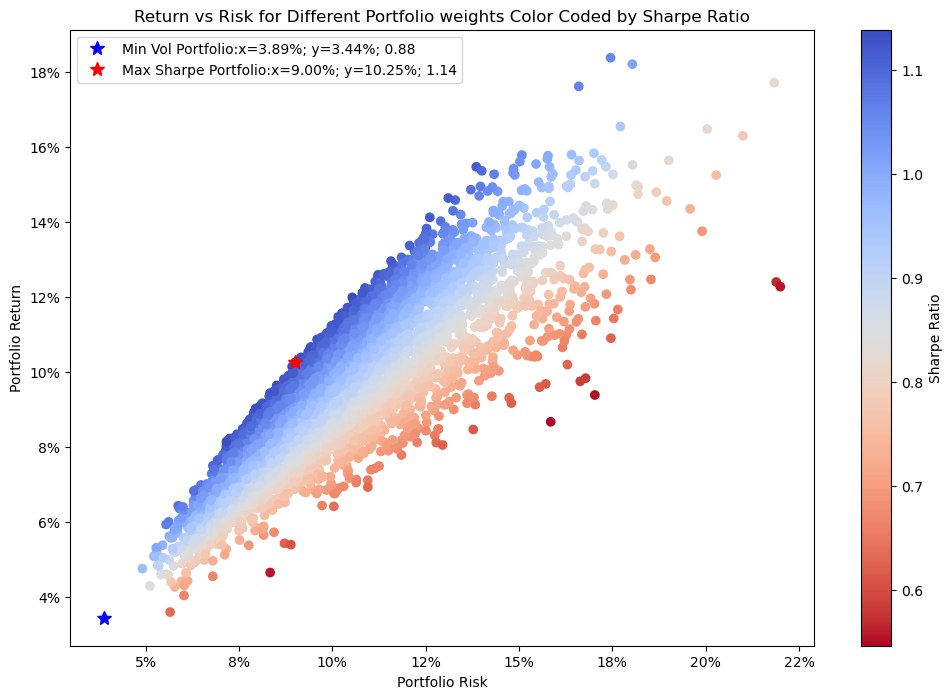

In [76]:
#Q12,Q13,Q14,Q15
plt.figure(figsize=aspect_ratio)
ax = plt.subplot()
plt.scatter(pvols, prets, c = prets/pvols, marker='o', cmap='coolwarm_r')
ax.xaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=0))
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=0))
plt.title('Return vs Risk for Different Portfolio weights Color Coded by Sharpe Ratio')
plt.xlabel('Portfolio Risk')
plt.ylabel('Portfolio Return')
plt.colorbar(label='Sharpe Ratio')
plt.plot(pvols[np.argmin(pvols)], prets[np.argmin(pvols)], 'b*', markersize=10.0, label='Min Vol Portfolio:x={:.2%}; y={:.2%}; {:1.2f}'.format(pvols[np.argmin(pvols)], prets[np.argmin(pvols)], prets[np.argmin(pvols)]/pvols[np.argmin(pvols)])) 
plt.plot(pvols[np.argmax(prets/pvols)], prets[np.argmax(prets/pvols)], 'r*', markersize=10.0, label='Max Sharpe Portfolio:x={:.2%}; y={:.2%}; {:1.2f}'.format(pvols[np.argmax(prets/pvols)], prets[np.argmax(prets/pvols)], prets[np.argmax(prets/pvols)]/pvols[np.argmax(prets/pvols)]))
plt.legend()

In [77]:
#Q12,Q13,Q14,Q15
# Identify the portfolios with maximum Sharpe ratio and minimum risk (volatility)
max_sharpe_idx = np.argmax(prets / pvols)
min_vol_idx = np.argmin(pvols)

# Optimal portfolios
max_sharpe_portfolio = weights_array[max_sharpe_idx]
min_vol_portfolio = weights_array[min_vol_idx]

# Display the optimal weights for max Sharpe and min volatility portfolios
print("Max Sharpe Portfolio Weights:", max_sharpe_portfolio)
print("Min Volatility Portfolio Weights:", min_vol_portfolio)

Max Sharpe Portfolio Weights: [0.20448307 0.06725538 0.10774014 0.09857481 0.20042097 0.12809403
 0.10336999 0.09006161]
Min Volatility Portfolio Weights: [0.01885306 0.00413128 0.23651829 0.04851899 0.40430836 0.02609959
 0.05764585 0.20392458]


## Question 15

#### The max sharpe (1.14) is higher than the equal weighted portolio sharpe (1.033).

## Question 16

In [78]:
#Q16
max_sharpe_port = pd.DataFrame((max_sharpe_portfolio * myStrategies_df.copy()).sum(axis=1, skipna=False), columns=['Max Sharpe Portfolio'])
max_sharpe_portfolio_df = myStrategies_df.copy().join(max_sharpe_port, how='inner')

print(max_sharpe_portfolio_df)

max_sharpe_portfolio_stats = calcPerformanceStatistics(max_sharpe_portfolio_df)
max_sharpe_portfolio_stats

            AAPL-MAFlat  AMZN-BMK-MA  ATT-BB  EUR-MAShort  FBNDX-MAShort  \
2000-11-16         -0.0    -0.058905     0.0     0.005027       0.001423   
2000-11-17         -0.0    -0.013575    -0.0     0.006349      -0.001423   
2000-11-20          0.0    -0.061052     0.0    -0.004237       0.000000   
2000-11-21         -0.0    -0.062442    -0.0     0.008730       0.000000   
2000-11-22         -0.0     0.037931     0.0    -0.002012       0.002845   
...                 ...          ...     ...          ...            ...   
2018-12-24         -0.0    -0.024613    -0.0    -0.002985      -0.001303   
2018-12-26          0.0     0.090254     0.0     0.004658       0.003914   
2018-12-27         -0.0    -0.006315     0.0    -0.006759       0.002618   
2018-12-28          0.0     0.011144     0.0    -0.001224      -0.003924   
2018-12-31          0.0     0.016074     0.0    -0.002008      -0.001305   

            GE-MAShort  GOLD-MAShort  SPY-MAFlat  Max Sharpe Portfolio  
2000-11-16    

,AAPL-MAFlat,AMZN-BMK-MA,ATT-BB,EUR-MAShort,FBNDX-MAShort,GE-MAShort,GOLD-MAShort,SPY-MAFlat,Max Sharpe Portfolio
Average Annual Return,25.09%,22.59%,0.86%,1.58%,1.06%,14.63%,6.15%,6.99%,10.25%
Annual Risk,28.07%,50.28%,6.51%,10.09%,3.82%,31.07%,17.93%,11.13%,9.00%
Sharpe Ratio,0.893707,0.449367,0.132524,0.156544,0.278537,0.470853,0.343057,0.628377,1.138415
maxDD,-81.16%,-159.76%,-21.49%,-35.95%,-17.01%,-104.18%,-42.90%,-19.50%,-12.36%
Success Ratio,65.51%,51.56%,97.94%,51.27%,63.81%,51.63%,52.69%,69.62%,55.03%


### The Max Sharpe Portfolio has less average annual return but also has less annual risk. The Max Sharpe Portfolio obviously has the highest sharpe compared to the rest of the individual strategies. 

## Question 17

In [79]:
#Q17
dfMaxPort = max_sharpe_portfolio_df[['Max Sharpe Portfolio']].copy()

dfSPY = master_df[['SPY-BMK-MA']].copy()

# inner-join the two dF's
maxPortAndSpyPrices = dfMaxPort.join([dfSPY], how ='inner')

# next, we compute log returns of the original prices
logReturns = np.log(maxPortAndSpyPrices / maxPortAndSpyPrices.shift(1)).dropna()

# Drop rows with NaN or infinite values
logReturns_clean = logReturns.replace([np.inf, -np.inf], np.nan).dropna()

# let's not forget to remove the first NaN row
X = logReturns_clean.dropna()['SPY-BMK-MA']

X = sm.add_constant(X)

# AMZN returns are the dependent variable
y = logReturns_clean.dropna()['Max Sharpe Portfolio']

# note that the 'x' variable (or indedpendent variable) needs to be specified as a matrix which COULD have multiple columns
# i.e., the dependent variable can be regressed against MULTIPLE independent variables
# in our case, we have only independent variable + the constant alpha term
max_port_Reg = sm.OLS(y, X)

max_port_Reg = max_port_Reg.fit()

print(max_port_Reg.summary())

print(max_port_Reg.params)

                             OLS Regression Results                             
Dep. Variable:     Max Sharpe Portfolio   R-squared:                       0.045
Model:                              OLS   Adj. R-squared:                  0.045
Method:                   Least Squares   F-statistic:                     63.26
Date:                  Mon, 21 Oct 2024   Prob (F-statistic):           3.83e-15
Time:                          22:36:09   Log-Likelihood:                -2488.5
No. Observations:                  1334   AIC:                             4981.
Df Residuals:                      1332   BIC:                             4991.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1321      0.043

C:\Users\nisho\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
C:\Users\nisho\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


### The beta value is 0.209. This means, if the S&P 500 was to increase by 1%, the max sharpe porfolio is expected to increase by less than 1%

C:\Users\nisho\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
C:\Users\nisho\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


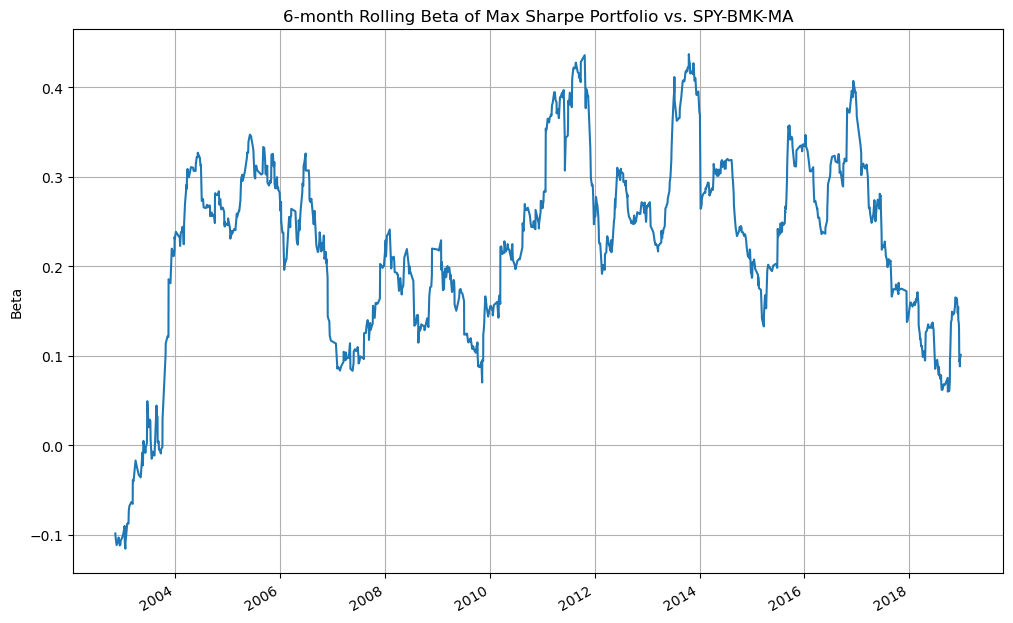

In [80]:
#Q17
dfMaxPort = max_sharpe_portfolio_df[['Max Sharpe Portfolio']].copy()

dfSPY = master_df[['SPY-BMK-MA']].copy()

# inner-join the two dF's
maxPortAndSpyPrices = dfMaxPort.join([dfSPY], how ='inner')

maxPortAndSpyReturns = np.log(maxPortAndSpyPrices.copy() / maxPortAndSpyPrices.shift(1)).dropna()

# Drop rows with NaN or infinite values
maxPortAndSpyReturns_clean = maxPortAndSpyReturns.replace([np.inf, -np.inf], np.nan).dropna()

maxPortRollingBetas = RollingOLS(maxPortAndSpyReturns_clean.dropna()['Max Sharpe Portfolio'], sm.add_constant(maxPortAndSpyReturns_clean.dropna()['SPY-BMK-MA']), window=126).fit()

maxPortRollingBetas.params[['SPY-BMK-MA']].style.format(na_rep='NaN')

# plot the rolling beta
#plt.figure(figsize=aspect_ratio)
#maxPortRollingBetas.params['SPY-BMK-MA'].plot(title='6-month Rolling Beta of Max Sharpe Portfolio vs. SPY-BMK-MA', ylabel='Beta', grid=True)
plot_and_format_y_axis(maxPortRollingBetas.params['SPY-BMK-MA'],title = '6-month Rolling Beta of Max Sharpe Portfolio vs. SPY-BMK-MA', ylabel='Beta')

### Now we've performed the rolling beta calculation to see how it fluctuates over time.

## Question 18

In [81]:
#Q18
BMK_Strategies = ['AAPL-BMK-MA', 'AMZN-BMK-MA', 'ATT-BMK-MA', 'AUD-BMK-MA', 'EUR-BMK-MA', 'FBNDX-BMK-MA', 'GE-BMK-MA', 'GOLD-BMK-MA', 'INTC-BMK-MA', 'LEHM-BMK-MA', 'SILVER-BMK-MA', 'SPY-BMK-MA']

myBMKStrategies_df = master_df[BMK_Strategies].copy()

equal_weights = np.array([1/12] * 12)
equal_weights_port = pd.DataFrame((equal_weights * myBMKStrategies_df.copy()).sum(axis=1, skipna=False), columns=['Equal Weights BMK Portfolio'])
myBMKStrategies_df_weighted = myBMKStrategies_df.copy().join(equal_weights_port, how='inner')
myBMKStrategies_df_weighted_stats = calcPerformanceStatistics(myBMKStrategies_df_weighted)
myBMKStrategies_df_weighted_stats

First row does not contain all NaNs. Inserting a NaN row at the top.


,AAPL-BMK-MA,AMZN-BMK-MA,ATT-BMK-MA,AUD-BMK-MA,EUR-BMK-MA,FBNDX-BMK-MA,GE-BMK-MA,GOLD-BMK-MA,INTC-BMK-MA,LEHM-BMK-MA,SILVER-BMK-MA,SPY-BMK-MA,Equal Weights BMK Portfolio
Average Annual Return,27.08%,22.59%,-4.01%,1.74%,1.67%,0.51%,-11.13%,9.06%,0.71%,1.02%,6.89%,3.35%,4.96%
Annual Risk,37.47%,50.28%,25.48%,13.20%,10.09%,3.82%,31.08%,17.92%,35.90%,3.75%,31.06%,19.39%,13.35%
Sharpe Ratio,0.722736,0.449367,-0.157282,0.131775,0.165528,0.133392,-0.358210,0.505744,0.019690,0.270804,0.221977,0.172766,0.371301
maxDD,-93.82%,-159.76%,-110.69%,-48.78%,-43.14%,-23.70%,-211.69%,-59.07%,-129.12%,-14.21%,-126.48%,-83.18%,-52.65%
Success Ratio,52.31%,51.56%,51.74%,52.86%,51.29%,64.67%,50.08%,53.00%,51.63%,52.42%,54.15%,54.17%,53.19%


In [82]:
MAFlat_Strategies = ['AAPL-MAFlat', 'AMZN-MAFlat', 'ATT-MAFlat', 'AUD-MAFlat', 'EUR-MAFlat', 'FBNDX-MAFlat', 'GE-MAFlat', 'GOLD-MAFlat', 'INTC-MAFlat', 'LEHM-MAFlat', 'SILVER-MAFlat', 'SPY-MAFlat']

myFlat_Strategies_df = master_df[MAFlat_Strategies].copy()

equal_weights = np.array([1/12] * 12)
equal_weights_port = pd.DataFrame((equal_weights * myFlat_Strategies_df.copy()).sum(axis=1, skipna=False), columns=['Equal Weights MAFlat Portfolio'])
myFlat_Strategies_df_weighted = myFlat_Strategies_df.copy().join(equal_weights_port, how='inner')
myFlat_Strategies_df_weighted_stats = calcPerformanceStatistics(myFlat_Strategies_df_weighted)
myFlat_Strategies_df_weighted_stats

First row does not contain all NaNs. Inserting a NaN row at the top.


,AAPL-MAFlat,AMZN-MAFlat,ATT-MAFlat,AUD-MAFlat,EUR-MAFlat,FBNDX-MAFlat,GE-MAFlat,GOLD-MAFlat,INTC-MAFlat,LEHM-MAFlat,SILVER-MAFlat,SPY-MAFlat,Equal Weights MAFlat Portfolio
Average Annual Return,25.09%,20.34%,-1.68%,1.39%,1.63%,0.79%,1.75%,7.61%,0.26%,0.69%,6.13%,6.99%,5.91%
Annual Risk,28.07%,33.38%,13.53%,8.55%,7.16%,2.65%,14.12%,14.41%,20.40%,2.98%,23.78%,11.13%,7.69%
Sharpe Ratio,0.893707,0.609319,-0.124529,0.162794,0.227103,0.296805,0.123856,0.527760,0.012514,0.231696,0.257702,0.628377,0.769179
maxDD,-81.16%,-100.87%,-46.79%,-39.49%,-20.08%,-11.69%,-29.55%,-43.84%,-81.58%,-12.70%,-69.97%,-19.50%,-17.61%
Success Ratio,65.51%,66.99%,77.69%,73.47%,71.15%,80.65%,74.51%,68.01%,73.47%,70.95%,77.12%,69.62%,54.79%


In [83]:
MAShort_Strategies = ['AAPL-MAShort', 'AMZN-MAShort', 'ATT-MAShort', 'AUD-MAShort', 'EUR-MAShort', 'FBNDX-MAShort', 'GE-MAShort', 'GOLD-MAShort', 'INTC-MAShort', 'LEHM-MAShort', 'SILVER-MAShort', 'SPY-MAShort']

myShort_Strategies_df = master_df[MAShort_Strategies].copy()

equal_weights = np.array([1/12] * 12)
equal_weights_port = pd.DataFrame((equal_weights * myShort_Strategies_df.copy()).sum(axis=1, skipna=False), columns=['Equal Weights MAShort Portfolio'])
myShort_Strategies_df_weighted = myShort_Strategies_df.copy().join(equal_weights_port, how='inner')
myShort_Strategies_df_weighted_stats = calcPerformanceStatistics(myShort_Strategies_df_weighted)
myShort_Strategies_df_weighted_stats

First row does not contain all NaNs. Inserting a NaN row at the top.


,AAPL-MAShort,AMZN-MAShort,ATT-MAShort,AUD-MAShort,EUR-MAShort,FBNDX-MAShort,GE-MAShort,GOLD-MAShort,INTC-MAShort,LEHM-MAShort,SILVER-MAShort,SPY-MAShort,Equal Weights MAShort Portfolio
Average Annual Return,23.10%,18.08%,0.64%,1.04%,1.58%,1.06%,14.63%,6.15%,-0.20%,0.36%,5.36%,10.64%,6.87%
Annual Risk,37.48%,50.28%,25.48%,13.20%,10.09%,3.82%,31.07%,17.93%,35.90%,3.75%,31.06%,19.38%,11.66%
Sharpe Ratio,0.616316,0.359660,0.025083,0.079040,0.156544,0.278537,0.470853,0.343057,-0.005465,0.096778,0.172605,0.549021,0.589541
maxDD,-117.64%,-152.00%,-80.26%,-49.94%,-35.95%,-17.01%,-104.18%,-42.90%,-142.93%,-25.40%,-70.48%,-33.36%,-24.07%
Success Ratio,52.66%,51.36%,51.01%,51.82%,51.27%,63.81%,51.63%,52.69%,51.03%,50.54%,53.17%,53.77%,53.46%


In [84]:
BB_Strategies = ['AAPL-BB', 'AMZN-BB', 'ATT-BB', 'AUD-BB', 'EUR-BB', 'FBNDX-BB', 'GE-BB', 'GOLD-BB', 'INTC-BB', 'LEHM-BB', 'SILVER-BB', 'SPY-BB']

myBB_Strategies_df = master_df[BB_Strategies].copy()

equal_weights = np.array([1/12] * 12)
equal_weights_port = pd.DataFrame((equal_weights * myBB_Strategies_df.copy()).sum(axis=1, skipna=False), columns=['Equal Weights BB Portfolio'])
myBB_Strategies_df_weighted = myBB_Strategies_df.copy().join(equal_weights_port, how='inner')
myBB_Strategies_df_weighted_stats = calcPerformanceStatistics(myBB_Strategies_df_weighted)
myBB_Strategies_df_weighted_stats

First row does not contain all NaNs. Inserting a NaN row at the top.


,AAPL-BB,AMZN-BB,ATT-BB,AUD-BB,EUR-BB,FBNDX-BB,GE-BB,GOLD-BB,INTC-BB,LEHM-BB,SILVER-BB,SPY-BB,Equal Weights BB Portfolio
Average Annual Return,-3.92%,-0.10%,0.86%,-0.37%,0.38%,0.10%,-0.99%,0.95%,-0.30%,-0.06%,0.20%,0.45%,-0.23%
Annual Risk,10.28%,12.56%,6.51%,2.39%,1.30%,0.75%,11.33%,4.57%,10.36%,0.68%,8.91%,4.04%,2.46%
Sharpe Ratio,-0.381856,-0.008100,0.132524,-0.156060,0.294958,0.138858,-0.087604,0.207221,-0.029328,-0.092340,0.022050,0.110627,-0.095494
maxDD,-85.38%,-44.02%,-21.49%,-11.14%,-2.15%,-3.62%,-49.57%,-9.51%,-45.23%,-3.40%,-25.52%,-10.74%,-9.79%
Success Ratio,94.65%,93.39%,97.94%,98.89%,99.36%,98.70%,93.57%,97.39%,95.53%,98.41%,97.04%,98.50%,76.25%


### None of these 4 portfolios outperform our chosen maxsharpe portfolio

"We pledge on our honor that we have not given nor received any unauthorized assistance on this assignment to/from other groups. Nor have we received any assistance from prior year students."
- Nishok Ilangovan, Rohan Sivarapu, Rohit Ananthan, Sandeepkumar Vijaya Kumar